# Daylight Saving Effect on Heart Attack

We will use the [healthcare dataset from Kaggle](https://www.kaggle.com/datasets/prasad22/healthcare-dataset).

In [103]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dowhy.causal_identifier import backdoor
import networkx as nx
from pgmpy.estimators import PC
from pgmpy.models import BayesianModel

from warnings import filterwarnings
filterwarnings('ignore')

# Motivation and Data Processing - 10% of the grade

Motivation, description of dataset and causal questions, description of assumptions, show true causal graph or a reasonable guess (10% grade)

In [104]:
file_path = 'data/healthcare/healthcare_dataset.csv'
df = pd.read_csv(file_path)

We only consider the first visit of patients with hypertension.

In [105]:
filtered_df = df[df['Medical Condition'] == 'Hypertension']
filtered_df = filtered_df[~filtered_df['Name'].duplicated(keep='first')]

Let's see how many unique values each variable has.

In [106]:
for col_name in filtered_df.columns:
    print(f'{col_name}:{filtered_df[col_name].nunique()}')

Name:1668
Age:68
Gender:2
Blood Type:8
Medical Condition:1
Date of Admission:1113
Doctor:1643
Hospital:1597
Insurance Provider:5
Billing Amount:1668
Room Number:396
Admission Type:3
Discharge Date:1088
Medication:5
Test Results:3


We decide that the following variables are irrelevant for our analysis or have arbitrary data: ```['Doctor', 'Hospital', 'Room Number', 'Discharge Date']```. We can also drop ```'Name'``` since we already filtered by the first visit of unique individuals.

In [107]:
filtered_df = filtered_df.drop(columns=['Doctor', 'Hospital', 'Room Number', 'Discharge Date', 'Name'])

Let's see the unique values of the columns with less than 10 unique values. We print the column names contianing continuous data.

In [108]:
for col_name in filtered_df.columns:
    if filtered_df[col_name].nunique() <= 10:
        print(f'{col_name}:{filtered_df[col_name].unique()}')
    else:
        print(f'{col_name} is a continuous variable.')

Age is a continuous variable.
Gender:['Male' 'Female']
Blood Type:['AB+' 'O-' 'O+' 'A+' 'A-' 'B-' 'B+' 'AB-']
Medical Condition:['Hypertension']
Date of Admission is a continuous variable.
Insurance Provider:['Cigna' 'Medicare' 'UnitedHealthcare' 'Aetna' 'Blue Cross']
Billing Amount is a continuous variable.
Admission Type:['Urgent' 'Emergency' 'Elective']
Medication:['Lipitor' 'Paracetamol' 'Aspirin' 'Ibuprofen' 'Penicillin']
Test Results:['Abnormal' 'Inconclusive' 'Normal']


We aim to introduce a binary column: assigning a value of 1 if the admission date falls within a 3-month window surrounding the annual daylight saving time change in March (a period during which individuals typically adjust their schedules due to a one-hour reduction in sleep), and 0 otherwise. Our dataset spans the years 2018-2023, and we construct a dictionary pairing each year with the specific date of the daylight saving time transition.

In [109]:
daylight_saving_dates = {
    2018: '2018-03-25',
    2019: '2019-03-31',
    2020: '2020-03-29',
    2021: '2021-03-28',
    2022: '2022-03-27',
    2023: '2023-03-26'}

In [110]:
daylight_saving_dates = {year: pd.to_datetime(date) for year, date in daylight_saving_dates.items()}

filtered_df['daylight_saving_march'] = filtered_df['Date of Admission'].apply(lambda date: 1 
                                                                        if daylight_saving_dates[pd.to_datetime(date).year] <= pd.to_datetime(date) <= daylight_saving_dates[pd.to_datetime(date).year] + pd.DateOffset(months=3)
                                                                        else 0)

filtered_df['daylight_saving_before_march'] = filtered_df['Date of Admission'].apply(lambda date: 1 
                                                                        if daylight_saving_dates[pd.to_datetime(date).year] >= pd.to_datetime(date) >= daylight_saving_dates[pd.to_datetime(date).year] - pd.DateOffset(months=3)
                                                                        else 0)

Let's see how balanced is our data.

In [112]:
for col_name in filtered_df.columns:
    if filtered_df[col_name].nunique() <= 10:
        print(filtered_df[col_name].value_counts())
        print()

Gender
Male      842
Female    826
Name: count, dtype: int64

Blood Type
AB-    221
A+     212
A-     211
B+     209
O+     208
AB+    207
O-     205
B-     195
Name: count, dtype: int64

Medical Condition
Hypertension    1668
Name: count, dtype: int64

Insurance Provider
Cigna               352
Aetna               341
Medicare            334
UnitedHealthcare    321
Blue Cross          320
Name: count, dtype: int64

Admission Type
Urgent       589
Emergency    571
Elective     508
Name: count, dtype: int64

Medication
Lipitor        353
Penicillin     343
Ibuprofen      333
Aspirin        322
Paracetamol    317
Name: count, dtype: int64

Test Results
Abnormal        593
Inconclusive    546
Normal          529
Name: count, dtype: int64

daylight_saving_march
0    1247
1     421
Name: count, dtype: int64

daylight_saving_before_march
0    1295
1     373
Name: count, dtype: int64



We notice that 25% of Hypertension cases happen within 3 months after the daylight saving in March, whil 22% of the hypertension cases happen before the daylight saving time. Of course this is not enough, we shall see if the daylight saving actually affects the changes of getting hypertension. We come with our own hypothesis before applying any causal discovery algorithm.

In [113]:
for col_name in filtered_df.columns:
    print(col_name)

Age
Gender
Blood Type
Medical Condition
Date of Admission
Insurance Provider
Billing Amount
Admission Type
Medication
Test Results
daylight_saving_march
daylight_saving_before_march


We can already form some hypothesis. We can motivate to follow this work in this case.

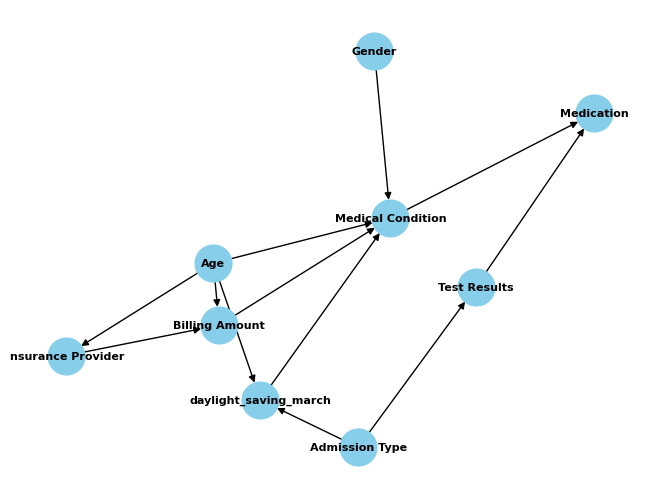

In [116]:
variables = ['Age', 'Gender', 'Medical Condition',
             'Insurance Provider', 'Billing Amount', 'Admission Type', 
             'Medication', 'Test Results', 'daylight_saving_march']

G = nx.DiGraph()
G.add_nodes_from(variables)

edges = [
    ('daylight_saving_march', 'Medical Condition'),
    ('Age', 'Medical Condition'),
    ('Age', 'daylight_saving_march'),
    ('Gender', 'Medical Condition'),
    ('Admission Type', 'daylight_saving_march'),
    ('Medical Condition', 'Medication'),
    ('Age', 'Insurance Provider'),
    ('Admission Type', 'Test Results'),
    ('Billing Amount', 'Medical Condition'),
    ('Age', 'Billing Amount'),
    ('Insurance Provider', 'Billing Amount'),
    ('Test Results', 'Medication')
]

G.add_edges_from(edges)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_size=8, node_size=700, node_color='skyblue', font_color='black', font_weight='bold', arrowsize=10)

plt.show()

# Exploratory Data Analysis - 15% of the grade

Testing correlations/conditional independences (15% grade, follow Tutorial 1&2)

# Identify estimands for backdoor, frontdoor criterion and IVs - 20% of the grade

If they apply, or explain why they don't apply (20% grade, follow Tutorial 3 and 4)

# Estimate the causal effects - 15% of the grade

(e.g. linear, inverse propensity weighting, two stage linear-regression etc) to the estimands you have previously identified (15% grade, follow Tutorial 4)

# Causal discovery results - 20% of the grade

for at least one constraint-based (e.g. SGS, PC) and score-based algorithm (e.g. GES), explain why it works or it doesn't and what is identifiable (20% grade, follow Tutorials 5 and 6)

# Validation and sensitivity analysis - 20% of the grade

(e.g. refutation analysis in DoWhy) and Discussion on the assumptions and results (20% grade)